In [4]:
pip install mne

     |████████████████████████████████| 6.6 MB 2.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install GoogleDriveDownloader

Note: you may need to restart the kernel to use updated packages.


In [15]:
from google_drive_downloader import GoogleDriveDownloader as gdd
import numpy as np
import json
import mne
import matplotlib

In [16]:
dataset_ids = {
    1: '1ym3JqI4_ZYNSBLxoF1vNxI5Hsgur_tha',
    2: '1tJ5tHbE-2jwr0gA33Gd873lRPao-e4dF',
    3: '1tXdpY-mser01POaP6Qwixny6LjsXXoXB',
    4: '1T00cliWp5yqqbbWZ7-rf2X4tOUQ-PvIQ',
    5: '1CYsBFMul9zB_vCy0XD7XVfKUl8vihDYZ',
    6: '1io6jdALBKeopELWXahPzuAi6EfYDgviW',
    7: '1YDkheRDPNDR1ujsqqC_SY6cebWHkw9Xt',
    8: '1jjoQJFDCi7O9Q-iaReAPpQnxC-HIKpQi',
}
label_id = '1mD5MXoh6tfQJFXIvdw2MQsEu6vZka6C0'
desc = '14kYNBZYdttqmSS_Vz6Bm_ztG9Uw1MC0y'

# ALTERE O ID DO DATASET DE SUA ESCOLHA AQUI ##################################
DS = 6

In [17]:
gdd.download_file_from_google_drive(file_id=dataset_ids[DS],
                                    dest_path='files/data.npy',
                                    showsize=True)
# download do arquivo de marcações
gdd.download_file_from_google_drive(file_id=label_id,
                                    dest_path='files/labels.npy', showsize=True)

# download do arquivo de descrição
gdd.download_file_from_google_drive(file_id=desc,
                                    dest_path='files/descriptor.json',
                                    showsize=True)

In [18]:
X = np.load('files/data.npy')
y = np.load('files/labels.npy')
desc_file = open('files/descriptor.json')
descriptor = json.loads(desc_file.read())
desc_file.close()
print('Estruturas => dados', X.shape, 'labels', y.shape)

Estruturas => dados (125, 257, 1205) labels (125,)


In [19]:
#Os dados estão estruturados em numpy arrays.

#O "shape" (125, 257, 1205) para os dados EEG de X, significa que existem 125 trials (tradução aceitável: ensaio, julgamento), 257 channels que representam os eletrodos e 1205 dados que representam o potencial mensurado em ponto flutuante. Este é um array com três dimensões.

#O "shape" (125,) para os dados de labels ou marcadores y, apresentam qual é o eletrodo respectivo a cada trial. Os labels estão com valores numéricos como é mostrado a seguir, o que facilita o processamento, mas não é intuitivo.

In [20]:
print('Características do voluntário:', descriptor[str(DS)])
print('\nRótulos:', descriptor['frequencies'])
print('\nTaxa de amostragem:', descriptor['sampling_rate'])

Características do voluntário: {'age': '31', 'capsize': 'Adult Medium', 'gender': 'Female', 'hairtype': 'Thick', 'handedness': 'Right'}

Rótulos: {'1': 6.66, '2': 7.5, '3': 8.57, '4': 10.0, '5': 12.0}

Taxa de amostragem: 250


In [21]:
X = X[:,:256,:]
ch_names = X.shape[1]
sfreq = X.shape[-1]
ch_types = 'eeg'

# objeto com o nome dos canais pelo modelo da touca utilizada
montage = mne.channels.make_standard_montage('EGI_256')

info = mne.create_info(ch_names=montage.ch_names, sfreq=250.0, ch_types=ch_types)
info.set_montage(montage)

<Info | 8 non-empty values
 bads: []
 ch_names: E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, ...
 chs: 256 EEG
 custom_ref_applied: False
 dig: 259 items (3 Cardinal, 256 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 256
 projs: []
 sfreq: 250.0 Hz
>

In [22]:
events = [[i, 0, e] for i, e in enumerate(y)]
obj = mne.EpochsArray(X, info, events=np.array(events))

125 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


In [23]:
obj

<EpochsArray  |   125 events (all good), 0 - 4.816 sec, baseline off, ~294.8 MB, data loaded,
 '1': 25
 '2': 25
 '3': 30
 '4': 25
 '5': 20>

In [24]:
#Remove frenquencias abaixo de 4hz e acima de 14hz
obj.filter(l_freq=4.0, h_freq=14.0)

Setting up band-pass filter from 4 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 413 samples (1.652 sec)



<EpochsArray  |   125 events (all good), 0 - 4.816 sec, baseline off, ~294.8 MB, data loaded,
 '1': 25
 '2': 25
 '3': 30
 '4': 25
 '5': 20>

In [25]:
epoch_p = obj.copy().pick_channels(['E115', 'E116', 'E122', 'E123', 'E124', 'E125','E135', 'E137', 'E138', 'E149', 'E150', 'E157','E158', 'E159', 'E167', 'E147'])

    Using multitaper spectrum estimation with 7 DPSS windows


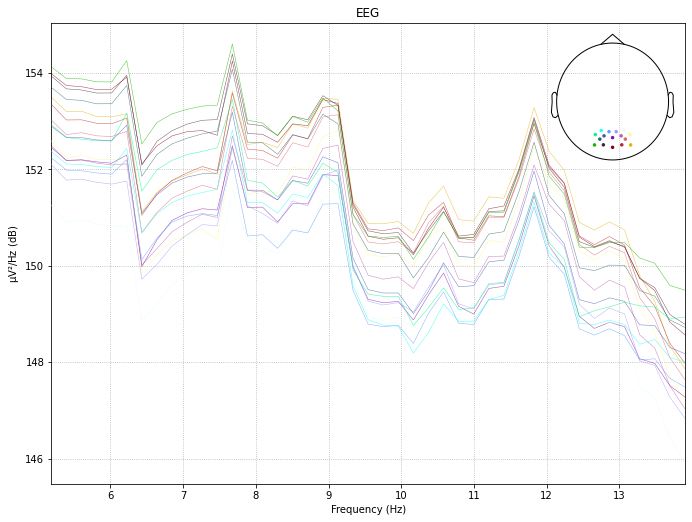

    Using multitaper spectrum estimation with 7 DPSS windows


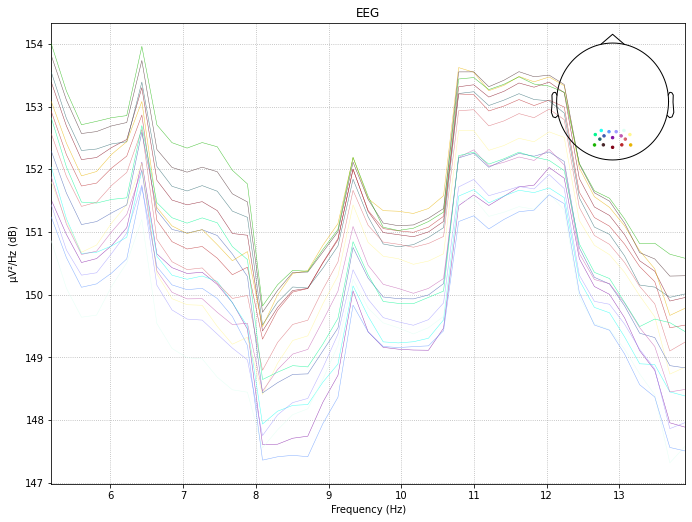

    Using multitaper spectrum estimation with 7 DPSS windows


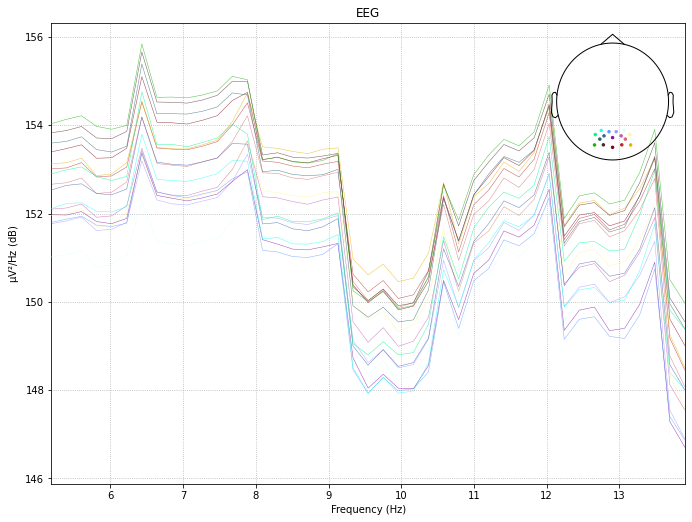

In [26]:
matplotlib.rcParams['figure.figsize'] = [11., 8.]

# escolhendo (filtrando) somente o evento '1'
e = '1'
# selecionando alguns trials aleatórios (3, 9 e 11)
for i in (3,9,11):
    epoch_p[e][i].plot_psd(fmin=5., fmax=14.)
